**Sam Alim Ramadhan**

**1103210236**

**UTS**

**Train**

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from imblearn.over_sampling import SMOTE
from xgboost import XGBRegressor
from google.colab import drive
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# **TRAIN**

Shell berikut merupakan metode mounting untuk menghubungkan program ke GDrive dan mengambil file berdasarkan path nya.

In [ ]:
drive.mount('/content/drive')
url = "/content/drive/MyDrive/Machine Learning/UTS/Dataset/train.csv"
data = pd.read_csv(url)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-91c2128fd521>:3: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(url)


# Data Format

Shell-shell berikut merupakan proses data formatting untuk mengubah tipe data fitur-fitur seperti Age, Num_of_Loan, Num_of_Delayed_Payment, Annual_Income dan seterusnya (seperti yang tertera di setiap shell nya) menjadi numerik. Selain mengubah tipe data, data format tersebut juga berfungsi untuk menghilangkan karakter-karakter di dalam data seperti '-', '_', dan sebagainya.

In [ ]:
data['Age'] = data['Age'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
data['Num_of_Loan'] = data['Num_of_Loan'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
data['Num_of_Delayed_Payment'] = data['Num_of_Delayed_Payment'].fillna('0').str.extract('(\d+)').astype(float).astype(int)

In [ ]:
data['Annual_Income'] = data['Annual_Income'].str.replace(r'[^0-9.]', '', regex=True)
data['Annual_Income'] = data['Annual_Income'].astype(float)

In [ ]:
data['Changed_Credit_Limit'] = data['Changed_Credit_Limit'].replace('_', np.nan)
data['Changed_Credit_Limit'] = pd.to_numeric(data['Changed_Credit_Limit'], errors='coerce')
data['Changed_Credit_Limit'] = data['Changed_Credit_Limit'].fillna(0)

In [ ]:
data['Outstanding_Debt'] = data['Outstanding_Debt'].astype(str)
data['Outstanding_Debt'] = data['Outstanding_Debt'].str.replace(r'[^0-9.]', '', regex=True)
data['Outstanding_Debt'] = pd.to_numeric(data['Outstanding_Debt'], errors='coerce')
data['Outstanding_Debt'] = data['Outstanding_Debt'].fillna(0)

In [ ]:
data['Amount_invested_monthly'] = data['Amount_invested_monthly'].astype(str)
data['Amount_invested_monthly'] = data['Amount_invested_monthly'].replace('', '0')
data['Amount_invested_monthly'] = data['Amount_invested_monthly'].str.replace(r'[^0-9.]', '')
data['Amount_invested_monthly'] = pd.to_numeric(data['Amount_invested_monthly'], errors='coerce')
data['Amount_invested_monthly'] = data['Amount_invested_monthly'].fillna(0)


In [ ]:
data['Monthly_Balance'] = data['Monthly_Balance'].astype(str)
data['Monthly_Balance'] = data['Monthly_Balance'].str.replace(r'[^0-9.-]+', '')
data['Monthly_Balance'] = pd.to_numeric(data['Monthly_Balance'], errors='coerce')
data['Monthly_Balance'] = data['Monthly_Balance'].fillna(0)

Shell berikut merupakan metode untuk mengonversi Age yang awalnya berbentuk string menjadi numerik berdasarkan jumlah bulan pada umur tersebut.

In [ ]:
def parse_years_and_months(age):
    if isinstance(age, str):
        age_parts = age.split(' Years and ')
        years = int(age_parts[0]) if 'Years' in age else 0
        months_str = age_parts[1].split(' Months')[0] if 'Months' in age_parts[1] else '0'
        months = int(months_str)
        total_months = years * 12 + months
        return total_months
    else:
        return 0

data['Credit_History_Age_Months'] = data['Credit_History_Age'].apply(parse_years_and_months)



# Duplicates

Shell berikut berfungsi untuk memeriksa apakah ada data yang di duplikasi pada dataset yang terkait. Jika ada, maka program akan memberitahu ada berapa data yang terduplikasi.

In [ ]:
duplicates = data[data.duplicated()]
num_duplicates = duplicates.shape[0]

if num_duplicates == 0:
    print("There are no duplicates")
else:
    print("There are", num_duplicates, "duplicates.")

There are no duplicates


# Data Scaling

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,100000.0,119.509700,6.847573e+02,14.000000,25.000000,34.000000,42.000000,8.698000e+03
Annual_Income,100000.0,176415.701298,1.429618e+06,7005.930000,19457.500000,37578.610000,72790.920000,2.419806e+07
Monthly_Inhand_Salary,84998.0,4194.170850,3.183686e+03,303.645417,1625.568229,3093.745000,5957.448333,1.520463e+04
Num_Bank_Accounts,100000.0,17.091280,1.174048e+02,-1.000000,3.000000,6.000000,7.000000,1.798000e+03
Num_Credit_Card,100000.0,22.474430,1.290574e+02,0.000000,4.000000,5.000000,7.000000,1.499000e+03
Interest_Rate,100000.0,72.466040,4.664226e+02,1.000000,8.000000,13.000000,20.000000,5.797000e+03
Num_of_Loan,100000.0,10.761960,6.178993e+01,0.000000,2.000000,3.000000,6.000000,1.496000e+03
Delay_from_due_date,100000.0,21.068780,1.486010e+01,-5.000000,10.000000,18.000000,28.000000,6.700000e+01
Num_of_Delayed_Payment,100000.0,28.779410,2.181148e+02,0.000000,8.000000,13.000000,18.000000,4.397000e+03
Changed_Credit_Limit,100000.0,10.171791,6.880628e+00,-6.490000,4.970000,9.250000,14.660000,3.697000e+01


Shell berikut berisi program yang berfungsi untuk menghilangkan baris baris yang memiliki nilai dengan persentil tertentu. Berdasarkan program, batas nilai persentilnya adalah 0.98. jika nilai persentil pada suatu baris melebihi batas tersebut, maka program akan menghilangkannya.

In [ ]:
selected_columns_data = data[['Num_Bank_Accounts', 'Interest_Rate', 'Annual_Income', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Total_EMI_per_month', 'Num_of_Loan', 'Num_Credit_Card']]

percentile_threshold = 0.98
percentiles = selected_columns_data.quantile(percentile_threshold)

for column in selected_columns_data.columns:
    data = data[data[column] <= percentiles[column]]

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,85806.0,120.486003,690.067511,14.000000,25.000000,34.000000,42.000000,8698.000000
Annual_Income,85806.0,49378.620726,36478.390299,7005.930000,19294.460000,36780.030000,70825.760000,166837.640000
Monthly_Inhand_Salary,72894.0,4105.781241,3036.319177,303.645417,1623.778333,3069.091667,5899.970000,14131.123333
Num_Bank_Accounts,85806.0,5.372759,2.585031,-1.000000,3.000000,6.000000,7.000000,10.000000
Num_Credit_Card,85806.0,5.779048,5.727016,0.000000,4.000000,5.000000,7.000000,171.000000
Interest_Rate,85806.0,14.551174,8.824173,1.000000,7.000000,13.000000,20.000000,128.000000
Num_of_Loan,85806.0,7.318381,18.881665,0.000000,2.000000,3.000000,6.000000,100.000000
Delay_from_due_date,85806.0,21.033483,14.786223,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_of_Delayed_Payment,85806.0,12.348321,6.845002,0.000000,8.000000,13.000000,18.000000,25.000000
Changed_Credit_Limit,85806.0,10.189597,6.867078,-6.490000,4.990000,9.280000,14.710000,36.970000


# Filtering

Shell-shell berikut berfungsi untuk menghapus karakter-karakter yang tidak bisa diproses pada model yang akan dibuat.

In [ ]:
data = data[data['Payment_Behaviour'] != '!@9#%8']

In [ ]:
data = data[data['Occupation'] != '_______']
print(data['Occupation'].unique())

['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']


In [ ]:
data = data[data['Credit_Mix'] != '_']
print(data['Credit_Mix'].unique())

['Good' 'Standard' 'Bad']


# Negative Values

Shell tersebut berisi program yang berfungsi untuk melakukan filtering data, dimana program hanya mengambil suatu data dengan nilai tertentu. Pada kasus ini, nilai tersebut adalah >= 0.

In [ ]:
selected_columns = ['Delay_from_due_date', 'Changed_Credit_Limit', 'Num_Bank_Accounts']

for column in selected_columns:
    data = data[data[column] >= 0]

# Dropping Columns

Shell berikut berfungsi untuk melakukan dropping atau menghilangkan kolom-kolom tertentu dan kemudian menyimpan hasil proses pada variabel yang berisi dataset di awal.

In [ ]:
columns_to_drop = ['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Credit_History_Age','Monthly_Inhand_Salary', 'Type_of_Loan']

data.drop(columns=columns_to_drop, inplace=True)


# Missing Values

Shell berikut berfungsi untuk melakukan pengecekan terhadap nilai null pada suatu baris data. jika terdapat nilai null, maka program akan memberitahu total nilai null yang telah dijumlahkan.

In [ ]:
total_missing_values = data.isnull().sum().sum()

if total_missing_values == 0:
    print("There are no missing values")
else:
    print("Total missing values:", total_missing_values)

There are no missing values


# Feature Engineering

Shell berikut berfungsi untuk melakukan visualisasi berbentuk grafik terhadap kolom-kolom numerik yang ada.

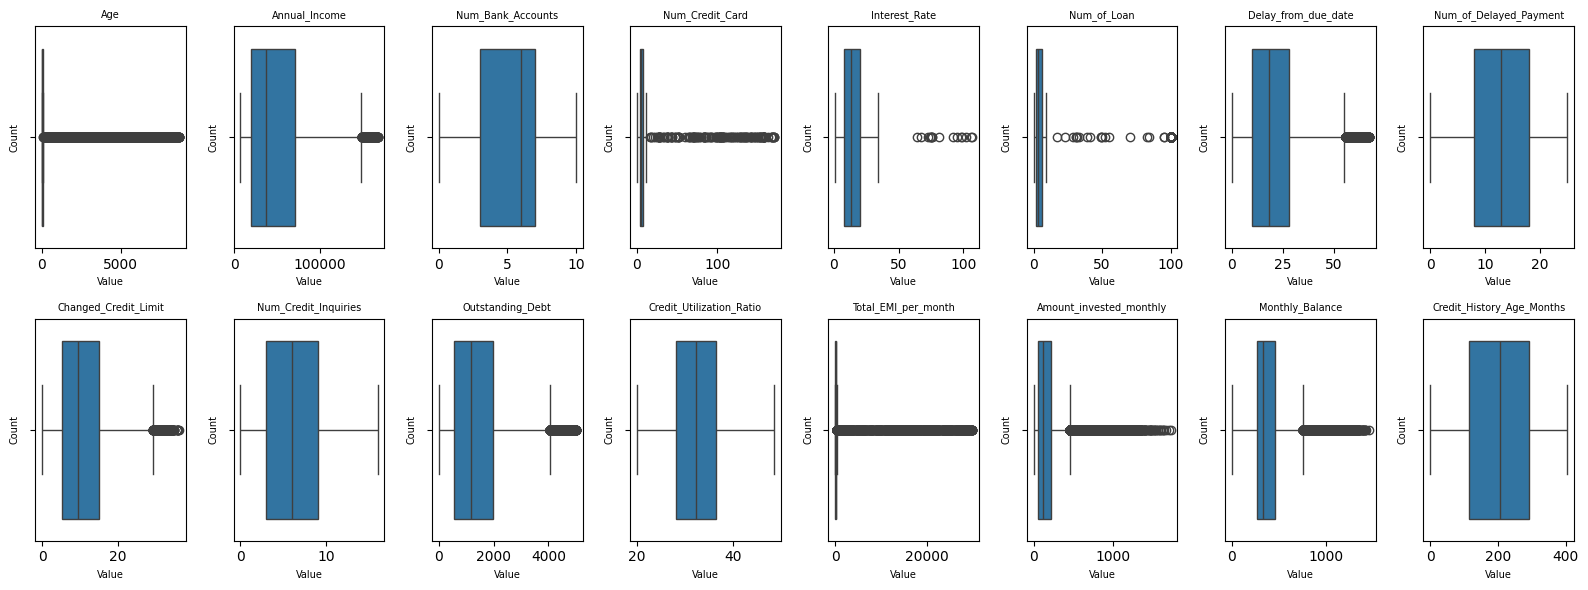

In [ ]:
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns

num_columns = 8
num_rows = (len(numeric_columns) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 6))

axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(x=data[column], ax=axes[i])
    axes[i].set_title(column, fontsize=7)
    axes[i].set_xlabel('Value', fontsize=7)
    axes[i].set_ylabel('Count', fontsize=7)

for j in range(len(numeric_columns), num_columns*num_rows):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# Scaling 2.0

Shell berikut berfungsi untuk mengambil nilai-nilai yang telah ditentukan batasnya pada kolom-kolom tertentu.

In [ ]:
data = data[data['Age'] < 60]
data = data[data['Num_Credit_Card'] <= 10]
data = data[data['Interest_Rate'] <= 50]
data = data[data['Num_of_Loan'] <= 12]
data = data[data['Num_Bank_Accounts'] <= 10]
data = data[data['Delay_from_due_date'] <= 60]
data = data[data['Changed_Credit_Limit'] <= 30]
data = data[data['Num_Credit_Inquiries'] <= 12]
data = data[data['Total_EMI_per_month'] <= 200]
data = data[data['Outstanding_Debt'] <= 1500]

# Encoding

# Label Encoder

Shell-shell berikut berfungsi untuk melakukan encoding terhadap kolom yang ditentukan. Kolom yang di encode akan merubah nilai yang awalnya bersifat kategorikal menjadi numerik.

In [ ]:
categories = ['Poor', 'Standard', 'Good']

encoder = OrdinalEncoder(categories=[categories])

data['Credit_Score_Encoded'] = encoder.fit_transform(data[['Credit_Score']])

In [ ]:
label_encoder = LabelEncoder()
data['Occupation_Encoded'] = label_encoder.fit_transform(data['Occupation'])

# Ordinal Encoder

Mirip seperti sebelumnya, shell-shell berikut juga melakukan encoding pada kolom-kolom yang telah ditentukan.

In [ ]:
categories = ['Bad', 'Standard', 'Good']

encoder = OrdinalEncoder(categories=[categories])

data['Credit_Mix_Encoded'] = encoder.fit_transform(data[['Credit_Mix']])

In [ ]:
categories_payment_behaviour = [
    'Low_spent_Small_value_payments',
    'Low_spent_Medium_value_payments',
    'Low_spent_Large_value_payments',
    'High_spent_Small_value_payments',
    'High_spent_Medium_value_payments',
    'High_spent_Large_value_payments'
]

encoder_payment_behaviour = OrdinalEncoder(categories=[categories_payment_behaviour])

data['Payment_Behaviour_Encoded'] = encoder_payment_behaviour.fit_transform(data[['Payment_Behaviour']])

# Dropping Unencoded Columns

Shell-shell berikut berfungsi untuk menghilangkan kolom-kolom tertentu yang tidak diencode.

In [ ]:
columns_to_drop = [ 'Payment_Behaviour', 'Credit_Mix', 'Occupation','Credit_Score']
data.drop(columns=columns_to_drop, inplace=True)

# New Feature

Shell berikut berfungsi untuk embuat fitur baru dengan mengkombinasikan dua fitur menjadi satu. Fitur-fitur yang dikombinasikan akan disimpan kedalam deklarasi fitur baru di dalam dataset.

In [ ]:
data['Total_Num_Accounts'] = data['Num_Bank_Accounts'] + data['Num_Credit_Card']

# Calculate the total outstanding debt per account

data['Debt_Per_Account'] = data['Outstanding_Debt'] / data['Total_Num_Accounts']

# Calculate the ratio of outstanding debt to annual income

data['Debt_to_Income_Ratio'] = data['Outstanding_Debt'] / data['Annual_Income']

# Calculate the total number of delayed payments per account

data['Delayed_Payments_Per_Account'] = data['Num_of_Delayed_Payment'] / data['Total_Num_Accounts']

# Calculate the total monthly expenses (EMI + Monthly Investments)

data['Total_Monthly_Expenses'] = data['Total_EMI_per_month'] + data['Amount_invested_monthly']

# MI Score

Shell berikut berisi program yang berfungsi untuk mencari nilai Mutual Informatio Score. Program ini bertujuan untuk mengodekan variabel kategorikal dalam dataset menggunakan metode OrdinalEncoder dan menghitung skor informasi mutual (mutual information score) menggunakan metode mutual_info_classif.

In [ ]:
categorical_columns = data.select_dtypes(include=['object']).columns

data_encoded = data.copy()

encoder = OrdinalEncoder()
data_encoded[categorical_columns] = encoder.fit_transform(data_encoded[categorical_columns])

y = data_encoded['Credit_Score_Encoded']
X = data_encoded.drop(columns=['Credit_Score_Encoded'])

mi_scores = mutual_info_classif(X, y)

for i, score in enumerate(mi_scores):
    print(f"Feature '{X.columns[i]}': Mutual Information Score = {score}")

Feature 'Age': Mutual Information Score = 0.005225933923882264
Feature 'Annual_Income': Mutual Information Score = 0.42858177664004327
Feature 'Num_Bank_Accounts': Mutual Information Score = 0.05329025706291479
Feature 'Num_Credit_Card': Mutual Information Score = 0.07275626807253821
Feature 'Interest_Rate': Mutual Information Score = 0.10290300845283928
Feature 'Num_of_Loan': Mutual Information Score = 0.01919388806990896
Feature 'Delay_from_due_date': Mutual Information Score = 0.06752484185127705
Feature 'Num_of_Delayed_Payment': Mutual Information Score = 0.05169581429513426
Feature 'Changed_Credit_Limit': Mutual Information Score = 0.10377087382237327
Feature 'Num_Credit_Inquiries': Mutual Information Score = 0.029431877819147356
Feature 'Outstanding_Debt': Mutual Information Score = 0.4304126369886663
Feature 'Credit_Utilization_Ratio': Mutual Information Score = 0.0008940600062685711
Feature 'Payment_of_Min_Amount': Mutual Information Score = 0.07243253943088379
Feature 'Total_E

Shell berikut merupakan visualisasi dari hasil program sebelumnya.

In [ ]:
sorted_mi_scores = sorted(zip(X.columns, mi_scores), key=lambda x: x[1], reverse=True)
sorted_columns = [x[0] for x in sorted_mi_scores]
sorted_scores = [x[1] for x in sorted_mi_scores]

colorscale = 'Viridis'

fig = go.Figure(data=[go.Bar(x=sorted_columns, y=sorted_scores, marker=dict(color=sorted_scores, colorbar=dict(title='Mutual Information Score', len=0.5, y=0.2)))])

fig.update_layout(title='Mutual Information Scores for Each Feature',
                  xaxis_title='Features',
                  yaxis_title='Mutual Information Score')

fig.show()

Mirip seperti yang dilakukan sebelumnya, Shell berikut berisi program yang melakukan dropping terhadap kolom tertentu.

In [ ]:
columns_to_drop = [ 'Payment_of_Min_Amount', 'Age', 'Monthly_Balance', 'Total_Monthly_Expenses', 'Payment_Behaviour_Encoded', 'Amount_invested_monthly', 'Credit_Utilization_Ratio', 'Occupation_Encoded']
data.drop(columns=columns_to_drop, inplace=True)

# Model

Shell berikut berisi program yang melakukan metode datasplit dimana metode tersebut memisahkan antara fitur dan target pada dataset untuk melakukan pemodelan.

In [ ]:
y = data['Credit_Score_Encoded']

X = data[['Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Total_EMI_per_month',
       'Credit_History_Age_Months', 'Credit_Mix_Encoded', 'Total_Num_Accounts',
       'Debt_Per_Account', 'Debt_to_Income_Ratio', 'Delayed_Payments_Per_Account']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

Shell berikut berisi program yang memroses nilai MSE (Mean Squared Error). dengan menggunakan XGBRegressor, fitur, dan target yang telah dideklarasikan sebelumnya, program akan menghitung nilai MSE dan menampilkan nilainya.

In [ ]:
xgb_model = XGBRegressor(n_estimators=3500, learning_rate=0.05, random_state=77)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_xgb)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.162767004196021


Shell tersebut berisi program untuk menghitung akurasi dari training data asli dan data yang telah diproses dengan bantuan modul SMOTE.

In [ ]:
smote_params = {
    'sampling_strategy': 'auto',
    'random_state': 77,
    'k_neighbors': 5,
    'n_jobs': -1
}

smote = SMOTE(**smote_params)

X_train = data.drop('Credit_Score_Encoded', axis=1)
y_train = data['Credit_Score_Encoded']

X_smote, y_smote = smote.fit_resample(X_train, y_train)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.15, random_state=77)

xgb_classifier = XGBClassifier(n_estimators=1000, bootstrap=True)

xgb_classifier.fit(X_train_smote, y_train_smote)

print("Accuracy on training set:", xgb_classifier.score(X_train_smote, y_train_smote))

y_pred_smote = xgb_classifier.predict(X_test_smote)
accuracy_smote = accuracy_score(y_test_smote, y_pred_smote)

print("Accuracy on SMOTE test set:", accuracy_smote)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[07:50:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap" } are not used.




Accuracy on training set: 0.9988191701616516
Accuracy on SMOTE test set: 0.8992847254268574


# Accuracy Test

Shell berikut berisi program yang menampilkan confussion matrix menggunakan modul XGBClassifier dan elemen-elemen yang diperlukan.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[07:51:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap" } are not used.




Accuracy on original test set: 0.9860796374231143

Classification report for original test set:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       901
         1.0       0.99      0.99      0.99      3810
         2.0       0.98      0.99      0.98      1467

    accuracy                           0.99      6178
   macro avg       0.98      0.98      0.98      6178
weighted avg       0.99      0.99      0.99      6178



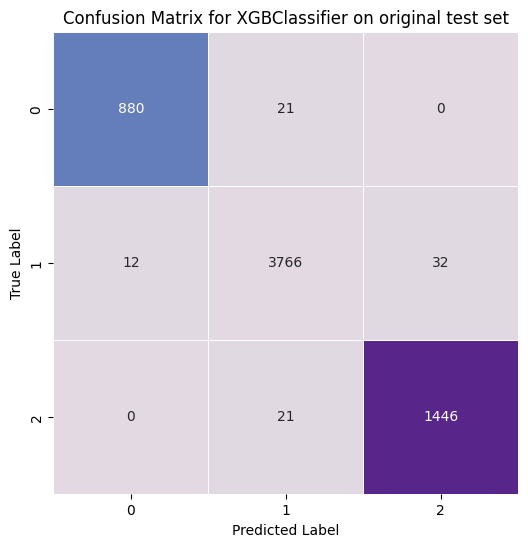

In [ ]:
xgb_classifier = XGBClassifier(n_estimators=500, bootstrap=True)
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on original test set:", accuracy)

matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(matrix, annot=True, cbar=False, cmap='twilight', linewidth=0.5, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for XGBClassifier on original test set')

print('\nClassification report for original test set:\n', classification_report(y_test, y_pred))

# **TEST**

Proses ini serupa seperti proses sebelumnya, hanya saja tidak memiliki credit_score untuk diproses. Oleh karena itu, proses ini membuat sendiri kolom tersebut dan menghitung jumlah nilai pada kolom credit_score berdasarkan kategorinya.

In [ ]:
url1 = "/content/drive/MyDrive/Machine Learning/UTS/Dataset/test.csv"
datatest = pd.read_csv(url1)

In [ ]:
datatest['Age'] = datatest['Age'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
datatest['Num_of_Loan'] = datatest['Num_of_Loan'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
datatest['Num_of_Delayed_Payment'] = datatest['Num_of_Delayed_Payment'].fillna('0').str.extract('(\d+)').astype(float).astype(int)

In [ ]:
datatest['Annual_Income'] = datatest['Annual_Income'].str.replace(r'[^0-9.]', '', regex=True)
datatest['Annual_Income'] = datatest['Annual_Income'].astype(float)

In [ ]:
datatest['Changed_Credit_Limit'] = datatest['Changed_Credit_Limit'].replace('_', np.nan)
datatest['Changed_Credit_Limit'] = pd.to_numeric(datatest['Changed_Credit_Limit'], errors='coerce')
datatest['Changed_Credit_Limit'] = datatest['Changed_Credit_Limit'].fillna(0)

In [ ]:
datatest['Outstanding_Debt'] = datatest['Outstanding_Debt'].astype(str)
datatest['Outstanding_Debt'] = datatest['Outstanding_Debt'].str.replace(r'[^0-9.]', '', regex=True)
datatest['Outstanding_Debt'] = pd.to_numeric(datatest['Outstanding_Debt'], errors='coerce')
datatest['Outstanding_Debt'] = datatest['Outstanding_Debt'].fillna(0)

In [ ]:
datatest['Amount_invested_monthly'] = datatest['Amount_invested_monthly'].astype(str)
datatest['Amount_invested_monthly'] = datatest['Amount_invested_monthly'].replace('', '0')
datatest['Amount_invested_monthly'] = datatest['Amount_invested_monthly'].str.replace(r'[^0-9.]', '')
datatest['Amount_invested_monthly'] = pd.to_numeric(datatest['Amount_invested_monthly'], errors='coerce')
datatest['Amount_invested_monthly'] = datatest['Amount_invested_monthly'].fillna(0)


In [ ]:
datatest['Monthly_Balance'] = datatest['Monthly_Balance'].astype(str)
datatest['Monthly_Balance'] = datatest['Monthly_Balance'].str.replace(r'[^0-9.-]+', '')
datatest['Monthly_Balance'] = pd.to_numeric(datatest['Monthly_Balance'], errors='coerce')
datatest['Monthly_Balance'] = datatest['Monthly_Balance'].fillna(0)

In [ ]:
def parse_years_and_months(age):
    if isinstance(age, str):
        age_parts = age.split(' Years and ')
        years = int(age_parts[0]) if 'Years' in age else 0
        months_str = age_parts[1].split(' Months')[0] if 'Months' in age_parts[1] else '0'
        months = int(months_str)
        total_months = years * 12 + months
        return total_months
    else:
        return 0

datatest['Credit_History_Age_Months'] = datatest['Credit_History_Age'].apply(parse_years_and_months)

# Data Entry

In [ ]:
datatest = datatest[datatest['Payment_Behaviour'] != '!@9#%8']
datatest = datatest[datatest['Occupation'] != '_______']
datatest = datatest[datatest['Credit_Mix'] != '_']

# Encoding

In [ ]:
label_encoder = LabelEncoder()
datatest['Occupation_Encoded'] = label_encoder.fit_transform(datatest['Occupation'])

categories = ['Bad', 'Standard', 'Good']
encoder = OrdinalEncoder(categories=[categories])

datatest['Credit_Mix_Encoded'] = encoder.fit_transform(datatest[['Credit_Mix']])

categories_payment_behaviour = [
    'Low_spent_Small_value_payments',
    'Low_spent_Medium_value_payments',
    'Low_spent_Large_value_payments',
    'High_spent_Small_value_payments',
    'High_spent_Medium_value_payments',
    'High_spent_Large_value_payments'
]

encoder_payment_behaviour = OrdinalEncoder(categories=[categories_payment_behaviour])

datatest['Payment_Behaviour_Encoded'] = encoder_payment_behaviour.fit_transform(datatest[['Payment_Behaviour']])

# New Feature

In [ ]:
datatest['Total_Num_Accounts'] = datatest['Num_Bank_Accounts'] + datatest['Num_Credit_Card']

datatest['Debt_Per_Account'] = datatest['Outstanding_Debt'] / datatest['Total_Num_Accounts']

datatest['Debt_to_Income_Ratio'] = datatest['Outstanding_Debt'] / datatest['Annual_Income']

datatest['Delayed_Payments_Per_Account'] = datatest['Num_of_Delayed_Payment'] / datatest['Total_Num_Accounts']

datatest['Total_Monthly_Expenses'] = datatest['Total_EMI_per_month'] + datatest['Amount_invested_monthly']

In [ ]:
columns_to_drop = [
    'ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
    'Monthly_Inhand_Salary', 'Type_of_Loan', 'Credit_Mix', 'Credit_Utilization_Ratio',
    'Payment_of_Min_Amount', 'Amount_invested_monthly', 'Payment_Behaviour',
    'Monthly_Balance', 'Occupation_Encoded', 'Payment_Behaviour_Encoded',
    'Total_Monthly_Expenses', 'Credit_History_Age'
]

datatest_cleaned = datatest.drop(columns=columns_to_drop)

# Predict

In [ ]:
y_pred = xgb_classifier.predict(datatest_cleaned)

# Result

In [ ]:
value_counts = pd.Series(y_pred).value_counts()
result = pd.DataFrame({'Credit Score': value_counts.index, 'Jumlah': value_counts.values})
result

,Credit Score,Jumlah
0,1,16821
1,0,12577
2,2,5123
